Transporting the [file](https://colab.research.google.com/drive/1h218X6qLhuaHv_AKPdch0PO8juI_lgyV#scrollTo=TaRlF7X49FN3) I created on google colab to a local notebook, to build a function out of it to eventually add to cormerant. I created on google colab to a local notebook, to build a function out of it to eventually add to cormerant.

In [28]:
## Initial Imports
# !pip install -q observable_jupyter==0.1.10
# !pip install geopandas
# !pip install s3fs
# !pip install rasterio
# !pip install -q tifffile

In [4]:
# Importing packages
import tifffile
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
# from observable_jupyter import embed
from math import cos, sin
# import s3fs
import rasterio
import pyarrow.parquet as pq
from shapely import wkt, wkb
import shapely

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd

from rasterio.windows import Window
from rasterio.enums import Resampling

In [5]:
from observable_jupyter import embed

# Functions

In [6]:
# Function

def read_transformation_matrix(dir,
                               file ='images/micron_to_mosaic_pixel_transform.csv'):
  # print('Loading from: ' + dir + file)
  mtx = pd.read_csv(dir + file, header=None, sep=' ').values

  # Returns to different formatted versions of the transformation matrix
  # for different downstream functions
  return mtx, [mtx[0][0], mtx[0][1],
          mtx[1][0], mtx[1][1],
          mtx[0][2], mtx[1][2]]

# A function to subset the metadata based on a window
def cell_window(md,
                cell_idx,
                number_of_cells = 50,
                window_size = 1000):
    

      number_of_cells = number_of_cells - 1
      cell = md.loc[cell_idx]

      window = [cell.center_x - window_size/2,
                cell.center_x + window_size/2,
                cell.center_y - window_size/2,
                cell.center_y + window_size/2]

      md_sub = deepcopy(md[(md.center_x > window[0]) &
                  (md.center_x < window[1]) &
                  (md.center_y > window[2]) &
                  (md.center_y < window[3])])

      md_sub.drop(cell_idx, inplace = True)

      if md_sub.shape[0] > number_of_cells:
        md_sub['distance_'] = (md_sub.center_x - cell.center_x)**2  + (md_sub.center_y - cell.center_y)**2


        md_sub = md_sub.sort_values('distance_').iloc[range(0,number_of_cells)]

      md_sub.loc[cell_idx] = cell
      return md_sub

def load_cell_boundaries_parquet(dir,
                                 local = True,
                                 filename = 'cell_boundaries.parquet'):

  # Reading in depends if the file is local or hosted on an amazon bucket
  if local == True:
    parquet_file = pq.ParquetFile(dir + filename)
  else:
    s3 = s3fs.S3FileSystem(anon=True)
    parquet_file = pq.ParquetFile(s3.open(dir + filename))

  # Get the total number of row groups
  num_row_groups = parquet_file.num_row_groups

  # Initializing an empty dataframe to append to
  cellBoundaries = gpd.GeoDataFrame()

  # Loop over all row groups
  for i in range(num_row_groups):
      # Read a specific row group
      row_group = parquet_file.read_row_group(i)

      # Convert to pandas DataFrame
      df = row_group.to_pandas()

      # Convert the DataFrame to a GeoDataFrame
      cellBoundaries = pd.concat([cellBoundaries,df])

  # cellBoundaries['geometry'] = cellBoundaries['Geometry'].apply(wkb.loads)
  # this process is very intensive and only necessary in later steps
  return cellBoundaries

# Three functions to process the cell boundaries
# Here we will use the first function since we have a subset of cells already.

def cell_boundaries_processing_id_subset(cb,
                            index_list,
                            id = 'EntityID'
                            ):
  boundaries_to_keep = [True if x in index_list else False for x in cb[id]]
  cb = deepcopy(cb[boundaries_to_keep])
  cb['geometry'] = cb['Geometry'].apply(wkb.loads)

  return gpd.GeoDataFrame(cb, geometry = 'geometry')

def cell_boundaries_processing_cell(cb,
                                    cell_idx,
                                    id = 'EntityID'):

  boundaries_to_keep = cb[id] == cell_idx
  cb = deepcopy(cb[boundaries_to_keep])
  cb['geometry'] = cb['Geometry'].apply(wkb.loads)

  return gpd.GeoDataFrame(cb, geometry = 'geometry')


# def cell_boundaries_processing_window_subset(cb,
#                             window, # should be a list with 4 points
#                             ):
#   cb['geometry'] = cb['Geometry'].apply(wkb.loads)
#   cb = gpd.GeoDataFrame(cb, geometry = 'geometry')
#   cb['centroid'] = cb['geometry'].centroid

#   window_polygon = Polygon(list(zip(np.repeat(window[0:2],2),
#    [window[2],window[3],window[3],window[2]])))

#   boundaries_to_keep = window_polygon.contains(cb['centroid'])
#   cb = deepcopy(cb[boundaries_to_keep])
#   return gpd.GeoDataFrame(cb, geometry = 'geometry')

def load_image_subset_s3(path,
                      bounds,
                      z_index_number,
                      image_type = 'DAPI'):

  # Loading a subset of the data from a s3 bucket

  with rasterio.Env(AWS_NO_SIGN_REQUEST = 'YES'):
    with rasterio.open(path + 'images/mosaic_' + image_type + '_z' + str(z_index_number) + '.tif') as src:
      w = src.read(1, window = Window(bounds[0], bounds[1], bounds[2]- bounds[0],bounds[3] - bounds[1]))

  return w

def load_image_subset(path,
                      bounds,
                      z_index_number,
                      image_type = 'DAPI'):
    with rasterio.open(path + 'images/mosaic_' + image_type + '_z' + str(z_index_number) + '.tif') as src:
      w = src.read(1, window = Window(bounds[0], bounds[1], bounds[2]- bounds[0],bounds[3] - bounds[1]))

    return w

def load_window_transcripts_s3(base_url,
                               global_bounds,
                               remove_blanks = True):

  # print('load_window_transcripts_s3')
  # Loading a generator of the csv file to read it by chunks
  trx_ini = pd.read_csv(base_url + 'partitioned_transcripts.csv', usecols=[2,3,4,8,9],
                        chunksize = 1e6)
  # print('trx_ini made')
  # Creating an empty dataframe to load in transcripts within our region of interest
  transcripts = pd.DataFrame()

  # print('transcripts made')

  # Iterating through the row chunks of the transcript files
  # print('iterating')
  for index, trx in enumerate(trx_ini):
    # print(index)

    # Removing blanks
    if remove_blanks == True:
      trx = deepcopy(trx[~trx['gene'].str.contains('Blank')])

    # Only keeping transcripts within the ROI
    trx_keep = trx[(trx['global_x'] > global_bounds[0]) &
                  (trx['global_x'] < global_bounds[2]) &
                  (trx['global_y'] > global_bounds[1]) &
                  (trx['global_y'] < global_bounds[3])]


    # Saving the transcripts within the ROI
    if trx_keep.shape[0] > 0 :
      transcripts = pd.concat([transcripts, trx_keep])

  return transcripts


# def partition_transcripts(transcripts,
#                           cellBoundaries):
#   transcripts['partition'] = 2

#   for z in range(0,7):
#     t = transcripts[transcripts.global_z == z]
#     cb = cellBoundaries[cellBoundaries.ZIndex == z]

#     points = gpd.points_from_xy(x = t.global_x,
#                                 y = t.global_y)

#     res = np.array([geo.contains(points) for geo in cb.geometry])

#     transcripts.loc[transcripts.global_z == z,'partition'] = [sum(array_) for array_ in res.transpose()]

#   return transcripts

# Inputs

In [7]:
dir_ = '/Users/DouglasHannumJr/Desktop/s3_bucket_data/s3_bucket_data/'
number = 1000 # 805
window_size = 100 # 150
number_of_cells = 10

z_index_number = 0

# Full analysis

In [8]:
transformation_matrix, transformation_matrix2 = read_transformation_matrix(dir = dir_)

md = pd.read_csv(dir_ + 'cell_metadata.csv', index_col = 0)

cell_idx = md.index[number]
cell = md.iloc[number]

# Subsetting the metadata
md_sub = cell_window(md, cell_idx, window_size = window_size, number_of_cells = number_of_cells)

In [8]:
import random
md_sub['cluster'] = random.choices(['Neuron','Glial','Immune'], k = md_sub.shape[0])

In [9]:
md_sub

,fov,volume,center_x,center_y,min_x,min_y,max_x,max_y,anisotropy,transcript_count,perimeter_area_ratio,solidity,distance_,cluster
EntityID,,,,,,,,,,,,,,
121919181900000978,NaN,1405.342828,7384.354775,5323.849879,7377.287560,5315.117543,7394.373160,5334.039144,1.236602,758.0,0.496516,4.482167,104.932454,Immune
121919181900001018,NaN,866.946790,7374.644110,5320.058302,7364.435559,5315.333543,7380.765160,5325.831144,1.542305,512.0,0.496400,4.459117,293.606013,Glial
121919181900000979,NaN,1162.198804,7406.933174,5324.488120,7399.211560,5317.169543,7414.137161,5333.175144,1.149135,758.0,0.410710,4.513678,307.238629,Immune
121919181900001006,NaN,1790.091786,7403.133403,5299.876102,7393.487560,5289.737543,7411.437160,5307.363143,1.163463,1049.0,0.332210,5.503339,411.036065,Glial
121919181900000963,NaN,880.313735,7383.303632,5338.265603,7378.259560,5330.237544,7388.433160,5345.163144,1.467091,323.0,0.465019,5.118102,543.471875,Glial
121919181900000981,NaN,684.653158,7414.615979,5327.053841,7409.687560,5319.869543,7419.645161,5333.715144,1.397540,411.0,0.552307,4.183216,653.289736,Immune
121919181900001016,NaN,1086.133541,7379.098154,5286.944277,7365.947559,5280.557542,7387.353160,5292.567143,1.969446,400.0,0.425751,3.974346,1018.460163,Glial
121919181900001008,NaN,1047.547510,7361.181276,5327.206262,7355.903559,5317.709543,7370.397159,5334.687144,1.188971,392.0,0.423762,3.980683,1028.993645,Neuron
121919181900001042,NaN,1328.368822,7408.360252,5343.674417,7401.479560,5334.773544,7417.161161,5351.103144,1.207022,952.0,0.349239,5.395512,1032.204388,Glial


In [10]:
cellBoundaries = load_cell_boundaries_parquet(local = True,
                                              dir = dir_)

In [83]:
type(md_sub.index)

pandas.core.indexes.numeric.Int64Index

In [11]:
# Loading the cellboundaries from the subset data
cellBoundaries = cell_boundaries_processing_id_subset(cellBoundaries,
                              index_list = md_sub.index)

<Axes: >

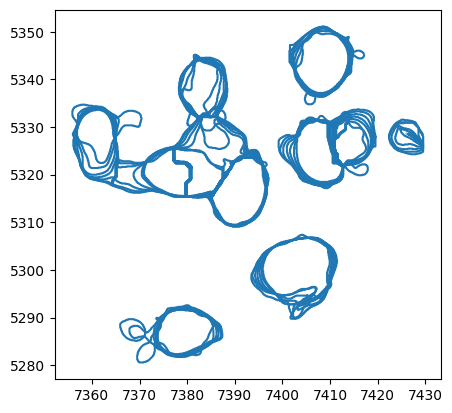

In [12]:
# Simple plot of the cell boundaries
cellBoundaries.boundary.plot()

In [84]:
cellBoundaries

,ID,EntityID,ZIndex,Geometry,ZLevel,Type,Name,ParentID,ParentType,geometry,...,min_x,min_y,max_x,max_y,anisotropy,transcript_count,perimeter_area_ratio,solidity,distance_,cluster
0,6617,121919181900000963,6,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,10.5,cell,None,None,None,"MULTIPOLYGON (((7388.433 5338.240, 7388.433 53...",...,7378.259560,5330.237544,7388.433160,5345.163144,1.467091,323.0,0.465019,5.118102,543.471875,Glial
1,6616,121919181900000963,5,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,9.0,cell,None,None,None,"MULTIPOLYGON (((7388.325 5339.104, 7388.325 53...",...,7378.259560,5330.237544,7388.433160,5345.163144,1.467091,323.0,0.465019,5.118102,543.471875,Glial
2,6615,121919181900000963,4,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,7.5,cell,None,None,None,"MULTIPOLYGON (((7388.217 5340.292, 7388.217 53...",...,7378.259560,5330.237544,7388.433160,5345.163144,1.467091,323.0,0.465019,5.118102,543.471875,Glial
3,6612,121919181900000963,1,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,3.0,cell,None,None,None,"MULTIPOLYGON (((7387.245 5340.292, 7387.245 53...",...,7378.259560,5330.237544,7388.433160,5345.163144,1.467091,323.0,0.465019,5.118102,543.471875,Glial
4,6613,121919181900000963,2,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,4.5,cell,None,None,None,"MULTIPOLYGON (((7387.785 5339.968, 7387.785 53...",...,7378.259560,5330.237544,7388.433160,5345.163144,1.467091,323.0,0.465019,5.118102,543.471875,Glial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,290666,121919181900042283,5,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,9.0,cell,None,None,None,"MULTIPOLYGON (((7429.539 5328.069, 7429.539 53...",...,7422.389446,5324.277934,7429.539046,5331.535534,1.202163,98.0,3.376412,3.078179,1380.785954,Neuron
73,290662,121919181900042283,1,b'\x01\x06\x00\x00\x00\x02\x00\x00\x00\x01\x03...,3.0,cell,None,None,None,"MULTIPOLYGON (((7426.083 5328.609, 7426.072 53...",...,7422.389446,5324.277934,7429.539046,5331.535534,1.202163,98.0,3.376412,3.078179,1380.785954,Neuron
74,290661,121919181900042283,0,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,1.5,cell,None,None,None,"MULTIPOLYGON (((7429.215 5326.449, 7429.215 53...",...,7422.389446,5324.277934,7429.539046,5331.535534,1.202163,98.0,3.376412,3.078179,1380.785954,Neuron
75,290663,121919181900042283,2,b'\x01\x06\x00\x00\x00\x01\x00\x00\x00\x01\x03...,4.5,cell,None,None,None,"MULTIPOLYGON (((7429.431 5326.017, 7429.420 53...",...,7422.389446,5324.277934,7429.539046,5331.535534,1.202163,98.0,3.376412,3.078179,1380.785954,Neuron


In [13]:
# Transforming the cell boundaries from global coordinates (microns)
# to pixel coordinates so it matches with the image data.
currentCells = cellBoundaries['geometry'].affine_transform(transformation_matrix2)

In [14]:
# Generating bounds for the data in pixel and global coordiantes
bounds = currentCells.total_bounds
global_bounds = cellBoundaries['geometry'].total_bounds

In [15]:
# Merging the metadata to the cellBoundaries data frame
cellBoundaries = cellBoundaries.merge(md_sub, left_on = 'EntityID', right_on = 'EntityID')

In [18]:
help(load_image_subset())

Help on function load_image_subset in module __main__:

load_image_subset(path, boundss, z_index_number, image_type='DAPI')



In [20]:
x = load_image_subset(path = dir_, bounds = bounds, z_index_number=z_index_number)

C:\Users\DouglasHannumJr\AppData\Roaming\Python\Python310\site-packages\rasterio\__init__.py:310: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [87]:
type(x)

numpy.ndarray

In [89]:
x

array([[1561, 1540, 1530, ..., 4280, 4429, 4598],
       [1543, 1560, 1537, ..., 4304, 4479, 4657],
       [1561, 1589, 1556, ..., 4317, 4532, 4720],
       ...,
       [2076, 2071, 2077, ..., 2948, 2946, 2861],
       [2030, 2032, 2039, ..., 2912, 2896, 2926],
       [2011, 2046, 2071, ..., 2851, 2888, 2863]], dtype=uint16)

In [90]:
dir_

'/Users/DouglasHannumJr/Desktop/s3_bucket_data/s3_bucket_data/'

In [91]:
transcripts = load_window_transcripts_s3(dir_, global_bounds=global_bounds)

In [48]:
%%capture
from PIL import Image
import base64
from io import BytesIO

# transcripts
#########################
# transcripts = transcripts[transcripts['fov'] == fov].copy()
temp = transcripts[['global_x', 'global_y']].values
transcript_positions = np.ones((temp.shape[0], temp.shape[1]+1))
transcript_positions[:, :-1] = temp
# Transform coordinates to mosaic pixel coordinates
transformed_positions = np.matmul(transformation_matrix, np.transpose(transcript_positions))[:-1]
transcripts.loc[:, 'local_x'] = transformed_positions[0, :]
transcripts.loc[:,'local_y'] = transformed_positions[1, :]
image = x

# segmentation data
#########################
currentCells = currentCells.reset_index(drop = True)

polygon_data = []
polygon_data3d = []
for idx in range(0,len(currentCells)):
    coordinates = []
    cell = currentCells[idx]
    for polygon in cell.geoms:
      coordinates.extend(list(polygon.exterior.coords))
    z_level = cellBoundaries.iloc[idx].ZIndex

    # change coordinate format
    coordinates = [list(ele) for ele in coordinates]

    # round coordinates
    coordinates = [[round(x, 2) for x in pair] for pair in coordinates]

    coordinates3d = [list(list(t) + [float(z_level * 15)]) for t in coordinates]
    inst_name = 'z' + str(cellBoundaries.iloc[idx].ZIndex)
    # inst_poly = {'coordinates': coordinates,
    #              'name': str(cellBoundaries.iloc[idx].EntityID),
    #              'z_level': float(z_level),
    #              'cell_type': str(cellBoundaries.iloc[idx].cluster),
    #              'z': z_level * 15,}
    inst_poly3d = {'coordinates': coordinates3d,
                   'name': str(cellBoundaries.iloc[idx].EntityID),
                   'z': np.float(z_level *15),
                   'cell_type': str(cellBoundaries.iloc[idx].cluster),
                   'z_idx': np.float(z_level)}
    # polygon_data.append(inst_poly)
    polygon_data3d.append(inst_poly3d)

df_obs = transcripts[['local_x', 'local_y', 'global_z', 'gene','cell_id']]
df_obs.columns = ['x', 'y', 'z', 'name','partition']
# round
df_obs['x'] = df_obs['x'].round(2)
df_obs['y'] = df_obs['y'].round(2)
df_obs['partition'] = df_obs['partition'].astype(float)
scatter_data = df_obs.to_dict('records')

def make_image_url(image_data):
    buffered = BytesIO()
    noise_img = Image.fromarray(image_data, 'RGB')
    noise_img.save(buffered, format='JPEG', quality=50) # change "PNG" to "JPEG", quality=70
    noise_img_str = base64.b64encode(buffered.getvalue())
    # noise_url = '"data:image/png;base64,'+ str(noise_img_str)[2:-1] + '"'
    noise_url = '"data:image/jpeg;base64,'+ str(noise_img_str)[2:-1] + '"'
    return noise_url

# image background
#########################
vmax=30000
tmpImage = deepcopy(np.flip(image, axis=0))
tmpImage[tmpImage > vmax] = vmax
tmpImage = tmpImage * (255/vmax)
tmpImage[tmpImage > 255] = 255
tmpImage = tmpImage.astype(np.int)

image_data = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
image_data[:,:, 0] = tmpImage
image_data[:,:, 1] = tmpImage
image_data[:,:, 2] = tmpImage
image_url = make_image_url(image_data)

# gene colors
#################
cats = df_obs.name.unique().tolist()
colors = []
for inst_index in range(len(cats)):
  if 'Blank' in cats[inst_index]:
    colors.append('#d3d3d3')
  else:
    mod_index = inst_index % 60
    if mod_index < 20:
      color_rgba = plt.cm.tab20(mod_index % 20)
    elif mod_index < 40:
      color_rgba = plt.cm.tab20b(mod_index % 20)
    elif mod_index < 60:
      color_rgba = plt.cm.tab20b(mod_index % 20)
    inst_color = '#{:02x}{:02x}{:02x}'.format( int(color_rgba[0]* 255), int(color_rgba[1]* 255), int(color_rgba[2]* 255))
    colors.append(inst_color)
cat_colors = dict(zip(cats, colors))

# cell colors
#################
cats = cellBoundaries.cluster.unique().tolist()
colors = []
for inst_index in range(len(cats)):
  mod_index = inst_index % 60
  if mod_index < 20:
    color_rgba = plt.cm.tab20(mod_index % 20)
  elif mod_index < 40:
    color_rgba = plt.cm.tab20(mod_index % 20)
  elif mod_index < 60:
    color_rgba = plt.cm.tab20(mod_index % 20)
  inst_color = '#{:02x}{:02x}{:02x}'.format( int(color_rgba[0]* 255), int(color_rgba[1]* 255), int(color_rgba[2]* 255))
  colors.append(inst_color)

cell_colors = dict(zip(cats, colors))


x_offset = np.float(bounds[0])
y_offset = np.float(bounds[1])
image_bounds = [[x_offset, y_offset], [x_offset, y_offset + image.shape[0]], [x_offset + image.shape[1], y_offset + image.shape[0]], [x_offset + image.shape[1], y_offset]]

In [49]:
# code for compressing data for visuals
import zlib, json, base64
def json_zip(j):
    zip_json_string = base64.b64encode(
        zlib.compress(
            json.dumps(j).encode('utf-8')
        )
    ).decode('ascii')
    return zip_json_string

In [50]:
zip_polygon_data3d = json_zip(polygon_data3d)
zip_scatter_data = json_zip(scatter_data)

In [51]:
fov_inputs = {
    # 'polygon_data3d': polygon_data3d,
    'zip_polygon_data3d': zip_polygon_data3d,
    'zip_scatter_data': zip_scatter_data,
    'image': image_url,
    'image_bounds': image_bounds,
    'center_x': np.mean([bounds[0], bounds[2]]),
    'center_y': np.mean([bounds[1], bounds[3]]),
    'zoom': -.5,
    'min_zoom': -3,
    'height': 800,
    'cat_colors': cat_colors,
    'cell_colors': cell_colors,
    'ini_opacity':1
    }


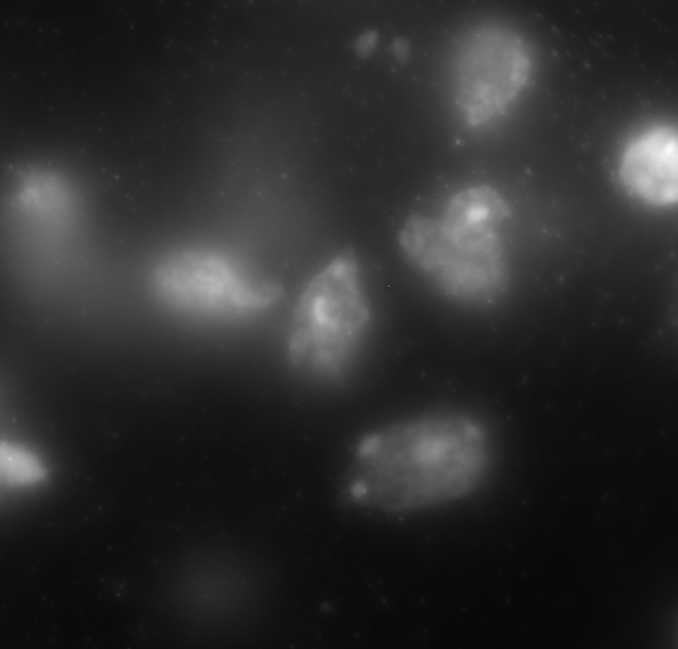

In [53]:
embed('@cellvisulization/2-3-2-deck-gl-image-polygon-scatter-3d', cells=['dashboard'], inputs=fov_inputs)